### Sourcing
The code in this notebook is adapted from Titouan Vayer's Paper and github repo found here: https://github.com/tvayer/FGW

In [1]:
import numpy as np
import os,sys
sys.path.append(os.path.realpath('/Users/jaredgridley/Projects/CryptoResearch2023/Papers/FGW/lib'))
from graph import graph_colors,draw_rel,draw_transp,Graph,wl_labeling
from ot_distances import Fused_Gromov_Wasserstein_distance,Wasserstein_distance
import copy
from data_loader import load_local_data,histog,build_noisy_circular_graph
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
# Want to invstigate the difference between sushi pools and sushi pool snapshots
sushi_liquidity = pd.read_csv("sushi_liquidity_positions.csv")

sushi_liquidity_snaps = pd.read_csv("sushi_liquidity_position_snapshots.csv")


In [3]:
liq_snap_blocks = list(sushi_liquidity_snaps["block"].sort_values().drop_duplicates())

In [195]:
# Now we are going to try to FGW comparison on two smaller graphs from SushiSwap

# Each subgraph will have 200 users
sushi_users = sushi_liquidity["user.id"].drop_duplicates()


graph1_users = sushi_users.sample(15, random_state=3)     # random state to get no cross over
graph1_df = sushi_liquidity[sushi_liquidity["user.id"].isin(graph1_users)]

graph2_users = sushi_users.sample(23, random_state=14)
graph2_df = sushi_liquidity[sushi_liquidity["user.id"].isin(graph2_users)]


In [196]:
from ot.gromov import gromov_wasserstein, fused_gromov_wasserstein

In [221]:
def draw_liquidity_pool_graph(df, user_name, lp_name, draw=True):

    G = nx.from_pandas_edgelist(df, user_name, lp_name)

    node_attributes = dict()

    colors = []
    for node in G:
        if node in df[user_name].values:
            node_attributes[node] = {"is_lp": 1}
            colors.append("blue")
        else:
            node_attributes[node] = {"is_lp": 0}
            colors.append("orange")
    
    nx.set_node_attributes(G, node_attributes)
    G = nx.convert_node_labels_to_integers(G, ordering="default", label_attribute="address")

    if draw:
        nx.draw(G, pos=nx.spring_layout(G), node_size=10,
                node_color=colors, with_labels=False)
        plt.show()
    return G, colors, node_attributes


In [222]:
G1, colors1, na1 = draw_liquidity_pool_graph(graph1_df, "user.id", "pair.id", False)
G2, colors2, na2 = draw_liquidity_pool_graph(graph2_df, "user.id", "pair.id", False)


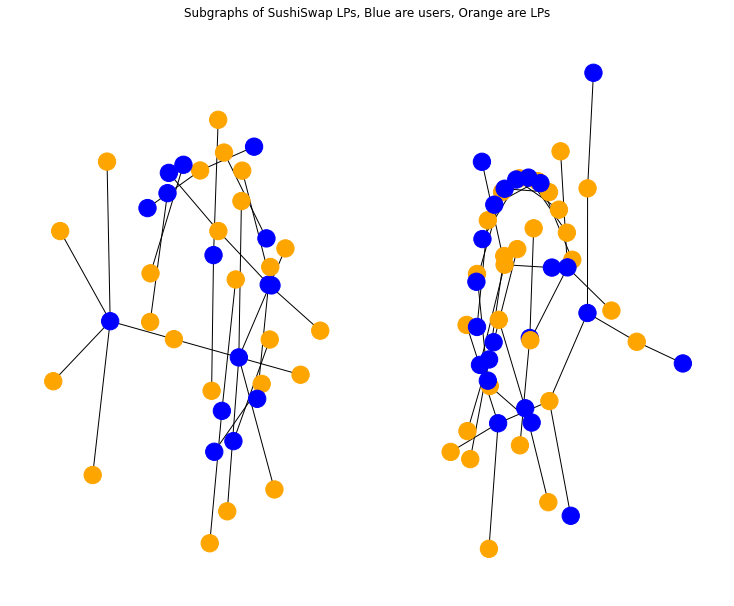

In [223]:
plt.figure(figsize=(10, 8))
vmin=0
vmax=7

draw_rel(G1, draw=False, vmin=vmin, vmax=vmax, with_labels=False, colors=colors1)
draw_rel(G2, draw=False, vmin=vmin, vmax=vmax, with_labels=False, shiftx=2, swipy=True, colors=colors2)
plt.title('Subgraphs of SushiSwap LPs, Blue are users, Orange are LPs')

plt.show()


In [224]:
def construct_paper_graph(G):
    g=Graph()

    gna1 = dict()
    gna2 = dict()
    for node in G:
        w = G.nodes[node]["is_lp"]
        gna2[node] = w

        neighbors = [n for n in G[node]]
        w *= len(neighbors)

        gna1[node] = w

    g.add_attibutes(gna1)
    g.add_attibutes(gna2)
    for u,v in G.edges():
        g.add_edge((u, v))
    
    return g

In [225]:
g1 = construct_paper_graph(G1)
g2 = construct_paper_graph(G2)

0 2
1 0
2 0
3 1
4 0
5 1
6 0
7 2
8 0
9 1
10 0
11 6
12 0
13 1
14 1
15 1
16 0
17 1
18 0
19 5
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 2
29 0
30 0
31 0
32 1
33 0
34 1
35 0
36 0
37 1
38 0
0 3
1 0
2 0
3 0
4 1
5 1
6 4
7 0
8 0
9 1
10 2
11 0
12 2
13 0
14 0
15 1
16 0
17 0
18 2
19 0
20 2
21 0
22 0
23 1
24 0
25 1
26 0
27 1
28 0
29 0
30 1
31 0
32 1
33 1
34 0
35 0
36 1
37 0
38 1
39 0
40 1
41 0
42 1
43 0
44 1
45 0
46 1
47 3
48 0
49 0
50 0


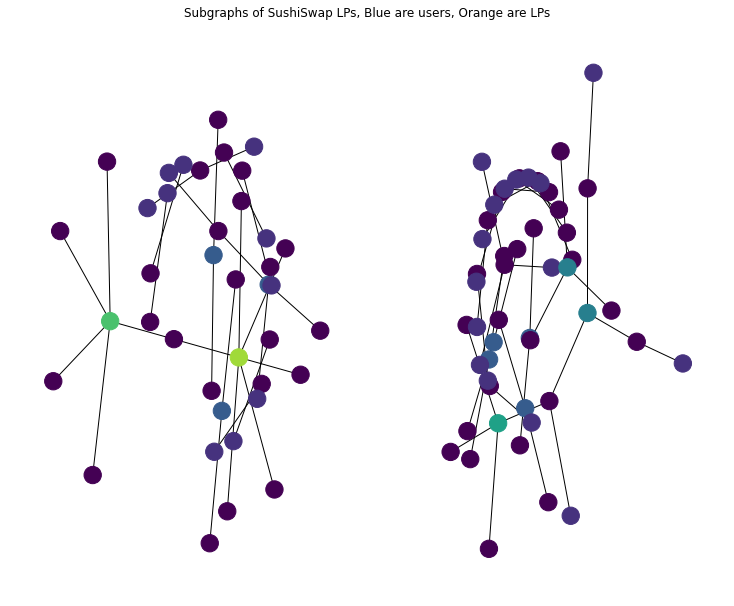

In [226]:
plt.figure(figsize=(10, 8))
vmin = 0
vmax = 7

draw_rel(g1.nx_graph, draw=False, vmin=vmin, vmax=vmax,
         with_labels=False)
draw_rel(g2.nx_graph, draw=False, vmin=vmin, vmax=vmax,
         with_labels=False, shiftx=2, swipy=True)
plt.title('Subgraphs of SushiSwap LPs, Blue are users, Orange are LPs')

plt.show()


In [233]:
g1.nodes()

{0: {'attr_name': 2},
 1: {'attr_name': 0},
 2: {'attr_name': 0},
 3: {'attr_name': 1},
 4: {'attr_name': 0},
 5: {'attr_name': 1},
 6: {'attr_name': 0},
 7: {'attr_name': 2},
 8: {'attr_name': 0},
 9: {'attr_name': 1},
 10: {'attr_name': 0},
 11: {'attr_name': 6},
 12: {'attr_name': 0},
 13: {'attr_name': 1},
 14: {'attr_name': 1},
 15: {'attr_name': 1},
 16: {'attr_name': 0},
 17: {'attr_name': 1},
 18: {'attr_name': 0},
 19: {'attr_name': 5},
 20: {'attr_name': 0},
 21: {'attr_name': 0},
 22: {'attr_name': 0},
 23: {'attr_name': 0},
 24: {'attr_name': 0},
 25: {'attr_name': 0},
 26: {'attr_name': 0},
 27: {'attr_name': 0},
 28: {'attr_name': 2},
 29: {'attr_name': 0},
 30: {'attr_name': 0},
 31: {'attr_name': 0},
 32: {'attr_name': 1},
 33: {'attr_name': 0},
 34: {'attr_name': 1},
 35: {'attr_name': 0},
 36: {'attr_name': 0},
 37: {'attr_name': 1},
 38: {'attr_name': 0}}

In [227]:
alpha=0.5
dfgw = Fused_Gromov_Wasserstein_distance(
    alpha=alpha, features_metric='dirac', method='shortest_path').graph_d(g1, g2)
dw = Wasserstein_distance(features_metric='dirac').graph_d(g1, g2)
dgw = Fused_Gromov_Wasserstein_distance(
    alpha=1, features_metric='dirac', method='shortest_path').graph_d(g1, g2)
print('Wasserstein distance={}, Gromov distance={} \nFused Gromov-Wasserstein distance for alpha {} = {}'.format(dw,dgw,alpha,dfgw))

Wasserstein distance=0.1176470588235294, Gromov distance=230.35842381969542 
Fused Gromov-Wasserstein distance for alpha 0.5 = 119.41238576879068


In [228]:
def merge_graph(g1, g2):
    gprime = nx.Graph(g1)
    N0 = len(gprime.nodes())
    g2relabel = nx.relabel_nodes(g2, lambda x: x + N0)
    gprime.add_nodes_from(g2relabel.nodes(data=True))
    gprime.add_edges_from(g2relabel.edges(data=True))
    gprime.add_edge(N0-1, N0)

    return gprime

g3=merge_graph(merge_graph(g1.nx_graph,merge_graph(g1.nx_graph,g2.nx_graph)),g2.nx_graph)
g4=merge_graph(merge_graph(g2.nx_graph,merge_graph(g1.nx_graph,g2.nx_graph)),g1.nx_graph)

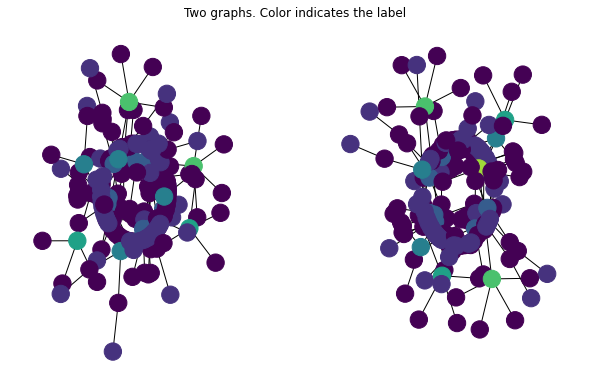

In [229]:
plt.figure(figsize=(8, 5))
draw_rel(g3, vmin=vmin, vmax=vmax, with_labels=False, draw=False)
draw_rel(g4, vmin=vmin, vmax=vmax, with_labels=False, shiftx=3, draw=False)
plt.title('Two graphs. Color indicates the label')
plt.show()


In [230]:
G1_p=Graph(g3)
G2_p=Graph(g4)

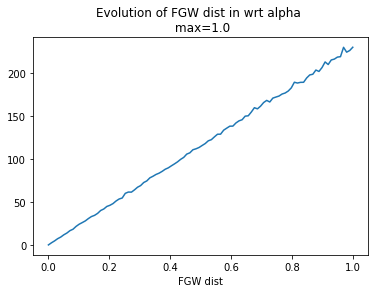

In [231]:
# We plot the evolution of the FGW distance with respect to the alpha parameter
alld = []
x = np.linspace(0, 1, 100)
for alpha in x:
    d = Fused_Gromov_Wasserstein_distance(
        alpha=alpha, features_metric='sqeuclidean').graph_d(g1, g2)
    alld.append(d)
plt.plot(x, alld)
plt.title('Evolution of FGW dist in wrt alpha \n max={}'.format(
    x[np.argmax(alld)]))
plt.xlabel('Alpha')
plt.xlabel('FGW dist')
plt.show()


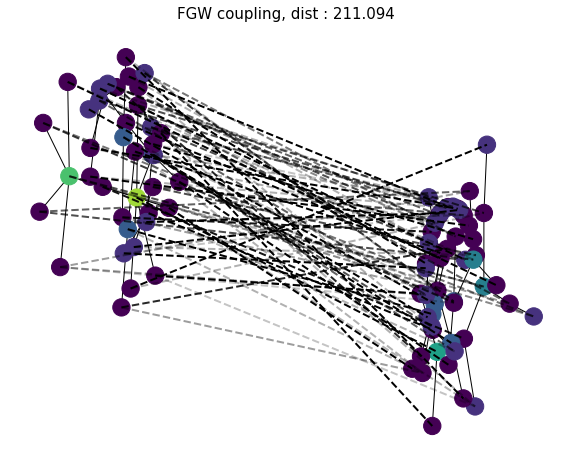

In [232]:
fig = plt.figure(figsize=(10, 8))
thresh = 0.004
gwdist = Fused_Gromov_Wasserstein_distance(
    alpha=.91, features_metric='sqeuclidean')
d = gwdist.graph_d(g1, g2)
plt.title('FGW coupling, dist : '+str(np.round(d, 3)), fontsize=15)
draw_transp(g1, g2, gwdist.transp, shiftx=4, shifty=0.5, thresh=thresh,
            swipy=True, swipx=False, with_labels=False, vmin=vmin, vmax=vmax)
plt.show()


In [1]:
g1.M

NameError: name 'g1' is not defined